In [1]:
import pandas as pd
from langdetect import detect
import string
import emoji
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
import mlflow
from mlflow import pyfunc
import requests
import boto3
import json
import nltk
from nltk import word_tokenize 
from nltk.stem import WordNetLemmatizer 
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vidhushinisrinivasan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/vidhushinisrinivasan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

<H2>Import Dataset</H2>

In [2]:

raw_github_data = pd.read_csv('data.tsv', sep='\t', header=0)

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
raw_github_data.head()

,github_repo_url,repo_description,topics,owner_repo_name,owner_name,owner_type,organization_bio,repo_created_day,primary_language_name,license_name,...,count_of_stars,count_of_watchers,count_distinct_contributors,count_contributions,count_commits,count_commit_comments,count_created_issues,count_pull_requests_created,count_pull_requests_reviews,count_comments_on_issues_and_pull_requests
0,https://github.com/CSSEGISandData/COVID-19,"novel coronavirus (covid-19) cases, provided b...","systems-science, covid-19, johns-hopkins-unive...",CSSEGISandData/COVID-19,CSSEGISandData,User,NaN,2020-02-04,NaN,NaN,...,19434,19417,2746,11609,3256,152,1669,361,119,6052
1,https://github.com/phildini/stayinghomeclub,a list of all the companies wfh or events chan...,"remote-work, covid19, covid-19, static-site",phildini/stayinghomeclub,phildini,User,NaN,2020-03-04,Ruby,cc0-1.0,...,456,453,1091,4156,1293,3,78,1350,934,498
2,https://github.com/tokyo-metropolitan-gov/covid19,東京都 新型コロナウイルス感染症対策サイト / tokyo covid-19 task fo...,covid-19,tokyo-metropolitan-gov/covid19,tokyo-metropolitan-gov,Organization,tokyo metropolitan government,2020-02-29,Vue,mit,...,5174,5165,537,11855,2774,2,906,1473,1533,5167
3,https://github.com/covid19india/covid19india-r...,📊 source code of the main website,"covid19-india, tracker, visualization, covid19...",covid19india/covid19india-react,covid19india,Organization,covid19-india ops,2020-03-15,JavaScript,mit,...,1676,1673,536,3029,348,6,424,316,167,1768
4,https://github.com/pcm-dpc/COVID-19,covid-19 italia - monitoraggio situazione,covid-19,pcm-dpc/COVID-19,pcm-dpc,Organization,NaN,2020-03-07,NaN,other,...,3072,3069,525,2197,171,10,451,49,42,1474


<h2> Clean Data</h2>

In [3]:
raw_github_data_filtered = raw_github_data[(raw_github_data['has_merged_prs'] == True) &
    (raw_github_data['has_readme'] == True) &
    (pd.isna(raw_github_data['repo_description']) == False) &
    (pd.isna(raw_github_data['primary_language_name']) == False) &
    (raw_github_data['count_distinct_contributors'] >=2)
]

<h2>Correlation Map</h2>

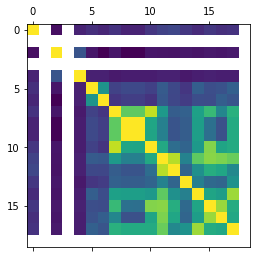

In [46]:
import matplotlib.pyplot as plt

plt.matshow(raw_github_data_filtered.corr())
plt.show()

<h2> Helper Functions </h2>

In [5]:
# Detect language with error handling
def detect_with_error_handle(x):
    try:
        return detect(x)
    except:
        return 'Error'
    
# Check for only latin characters
def has_only_latin_letters(text):
    char_set = string.printable + '—'
    return all((True if x in char_set else False for x in text))

# Remove punctuation
def remove_punctuation(text):
    punctuation_list = string.punctuation + '—'
    return text.translate(str.maketrans('', '', punctuation_list))

<h2>Text Processing</h2>

In [6]:
# check language, limit to english, and limit repo's with latin characters. Emojis are converted in the process
raw_github_data_filtered['language'] = raw_github_data_filtered['repo_description'].apply(lambda x: 'None' if pd.isna(x) else detect_with_error_handle(str(x)))
raw_github_data_filtered = raw_github_data_filtered[raw_github_data_filtered['language'] == 'en'].copy()
raw_github_data_filtered['is_latin_only_characters'] = raw_github_data_filtered['repo_description'].apply(lambda x: has_only_latin_letters(emoji.demojize(x)))
raw_github_data_filtered = raw_github_data_filtered[raw_github_data_filtered['is_latin_only_characters'] == True].copy()

# clean up repo description, topic, and language, combine into one big bag o' words
raw_github_data_filtered['repo_description_cleaned'] = raw_github_data_filtered['repo_description'].apply(lambda x: remove_punctuation(x))
raw_github_data_filtered['topics'] = raw_github_data_filtered.apply(lambda x: remove_punctuation(str(x['topics']).replace(',','').replace('nan','')), axis=1)
raw_github_data_filtered['topics'].fillna('', inplace=True)
raw_github_data_filtered['description_plus_topics'] = raw_github_data_filtered['repo_description_cleaned']+' '+raw_github_data_filtered['topics']+' '+raw_github_data_filtered['primary_language_name']
raw_github_data_filtered.reset_index(drop=True, inplace=True)

# create repo-lookup object for later use
repo_lookup = raw_github_data_filtered.copy()

<ipython-input-6-449ceb6bdf75>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_github_data_filtered['language'] = raw_github_data_filtered['repo_description'].apply(lambda x: 'None' if pd.isna(x) else detect_with_error_handle(str(x)))


<h2> Tokenizer </h2>

In [7]:
# Create class to be used by tokenizer to lemmatize... which change matches words to their roots
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<h2>Create Bert Embeddings for Input Data</h2>

In [35]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer('bert-large-nli-stsb-mean-tokens')

100%|██████████| 1.24G/1.24G [03:02<00:00, 6.82MB/s] 


In [36]:
corpus_embeddings_cleaned = embedder.encode(raw_github_data_filtered['description_plus_topics'])

/usr/local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:1458: DeprecationWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [45]:
corpus_embeddings_cleaned

array([[ 0.08335491, -0.273391  , -0.84478736, ...,  0.15537384,
        -0.02338627,  0.44419217],
       [-0.5071723 ,  0.00229374, -0.06180557, ...,  0.64270353,
         0.03400471,  1.3523257 ],
       [ 0.22075853,  0.47256142, -0.10161404, ...,  0.8410261 ,
         0.24130097,  1.0043257 ],
       ...,
       [ 0.5820951 , -0.6507479 ,  0.66174006, ..., -0.09759206,
         0.7494296 , -1.4188712 ],
       [-0.2891289 ,  0.32989588, -0.4120548 , ...,  0.7233281 ,
         0.10993961,  1.1797737 ],
       [-0.20110777, -0.12553403, -0.44665238, ...,  0.45139942,
        -0.18576165,  0.7206653 ]], dtype=float32)

<h2> Build Predicter </h2>

In [37]:
def text_recommender(input_df, embedder=embedder,  corpus_embeddings_cleaned = corpus_embeddings_cleaned, repo_lookup=repo_lookup):
    
    input_df['bag_of_words'] = input_df.apply(lambda x: ' '.join(x), axis = 1)
    
    # vectorize the inputted string
    #inputted_vector = word_vectorizer.transform(pd.Series(str(input_string)))
    inputted_vector = embedder.encode(input_df['bag_of_words'])
    
    # calculate cosine similarity with existing matrix
    one_dimension_cosine_sim = cosine_similarity(inputted_vector, corpus_embeddings_cleaned)

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(one_dimension_cosine_sim[0]).sort_values(ascending = False)
    # only show matches that have some similarity
    score_series = score_series[score_series>0]

    # getting the indexes of the 10 most similar repos
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # initializing the empty list of recommended repo
    
    recommended_repos = repo_lookup.loc[top_10_indexes]
        
    return recommended_repos

In [38]:
class covid19RepoReco(pyfunc.PythonModel):   
    ## defining objects needed for leadsModel prediction. 
    def __init__(self,
                 embedder,
                 corpus_embeddings_cleaned,
                 repo_lookup,
                 text_recommender):
        
        ## Setting up all needed objects
        self.embedder = embedder
        self.corpus_embeddings_cleaned = corpus_embeddings_cleaned
        self.repo_lookup = repo_lookup
        self.text_recommender = text_recommender
    
    ## define function with processing and feeding data into prediction at the end
    def predict(self,context,model_input):
        output_df = self.text_recommender(model_input)
        return [output_df.to_dict('records')]

<h2>Test</h2>

In [39]:
# Testing the prediction class before pushing to MLflow
m = covid19RepoReco(embedder = embedder,
                                       corpus_embeddings_cleaned = corpus_embeddings_cleaned,
                                       repo_lookup = repo_lookup,
                                       text_recommender = text_recommender)
model_input = pd.DataFrame([["Python", "Data"]])
model_output = m.predict(None,model_input)
print(model_output)

[[{'github_repo_url': 'https://github.com/jeffreysilver/stopcovid-lambdas', 'repo_description': 'www.stopcovid.co', 'topics': '', 'owner_repo_name': 'jeffreysilver/stopcovid-lambdas', 'owner_name': 'jeffreysilver', 'owner_type': 'User', 'organization_bio': nan, 'repo_created_day': '2020-03-18', 'primary_language_name': 'Python', 'license_name': nan, 'is_github_pages': False, 'has_readme': True, 'has_wiki': True, 'has_merged_prs': True, 'has_issues': True, 'has_contributor_guide': False, 'has_code_of_conduct': False, 'count_of_public_forks': 0, 'count_of_stars': 0, 'count_of_watchers': 0, 'count_distinct_contributors': 3, 'count_contributions': 727, 'count_commits': 470, 'count_commit_comments': 0, 'count_created_issues': 0, 'count_pull_requests_created': 87, 'count_pull_requests_reviews': 156, 'count_comments_on_issues_and_pull_requests': 14, 'language': 'en', 'is_latin_only_characters': True, 'repo_description_cleaned': 'wwwstopcovidco', 'description_plus_topics': 'wwwstopcovidco  Pyt

<h2>Log to MLflow</h2>

In [40]:
# connect to MLflow
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("Covid19RepoRecommender") # creates an experiment if it doesn't exist

/usr/local/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
mlflow_conda_env = {
 'name': 'mlflow-env',
 'channels': ['defaults',
              'conda-forge'],
 'dependencies': ['python=3.6.2',
                  'nltk=3.4.5',
                  'nltk_data',
                  {'pip': ['mlflow==1.6.0',
                           'scikit-learn',
                           'cloudpickle==1.2.2']}
                 ]
}

In [42]:
with mlflow.start_run(run_name="Covid Repo Recommender") as run:
    mlflow.log_param("num_repos_returned", 10)
    
    pyfunc.log_model(
        artifact_path = "covid_repo_reco_pyfunc",
        python_model = covid19RepoReco(embedder = embedder,
                                       corpus_embeddings_cleaned = corpus_embeddings_cleaned,
                                       repo_lookup = repo_lookup,
                                       text_recommender = text_recommender),
        conda_env = mlflow_conda_env
    )
    
    run_id = run.info.run_uuid
    experiment_id = run.info.experiment_id
    
    mlflow.end_run()

<h2>Test Local Deployment</h2>

In [29]:
# Run this command in the same directory as MLflow to kick-off a local sagemaker build

sagemaker_local_command = 'mlflow sagemaker run-local -m ./mlruns/{experiment_id}/{run_id}/artifacts/covid_repo_reco_pyfunc -p 5001'. \
    format(experiment_id=experiment_id,run_id=run_id)

print(sagemaker_local_command)

mlflow sagemaker run-local -m ./mlruns/1/be7ec6c8ff424583b2bad6d9dfd063b0/artifacts/covid_repo_reco_pyfunc -p 5001


In [30]:
# Building a function to test out the locally-build sagemaker container
def query_local_endpoint(input_json):
    response = requests.post('http://localhost:5001/invocations'
                           , headers = {'Content-Type': 'application/json'} 
                           , data=input_json)
    print(response)
    preds = response.json()
    return preds


In [ ]:
# Running a query against the local endpoint and examining the output
model_input = pd.DataFrame([["Python", "Data"]])
output=query_local_endpoint(model_input.to_json(orient="split"))
print(output)

<h2>Deploy to Sagemaker</h2>

In [ ]:
## If the local sagemaker testing went well, it's time to deploy!

## Note: this requires a MLflow pyfunc docker container to already exist in sagemaker

import mlflow.sagemaker as mfs


# we pull the run and experiment id's from above to create this mlflow location
model_uri = "mlruns/%s/%s/artifacts/covid_repo_reco_pyfunc" % (experiment_id,run_id)

# The region is chosen, pick whats close to you or your systems!
region = "us-east-1"
# The aws account id can be found in the console
aws_account_id = "XXXXXXX"
# We use these inputs to automatically reference the sagemaker docker container
image_url = aws_account_id \
            + ".dkr.ecr." \
            + region \
            + ".amazonaws.com/mlflow-pyfunc:1.5.0"

# now we specify the role that we setup for sagemaker in the previous step
sagemaker_arn = "arn:aws:iam::XXXXXXX:role/AmazonSageMakerFullAccess"


# finally, we pick a name for our endpoint within sagemaker
endpoint_name = "covid19-repo-rec" 


# with all of the inputs, we run the following to deploy the model it sagemaker
mfs.deploy(app_name=endpoint_name, 
           model_uri=model_uri,
           region_name=region,
           mode="create", #this should change to replace if the endpoint already exists
           execution_role_arn=sagemaker_arn,
           image_url=image_url, 
           instance_type='ml.t2.medium')